<a href="https://colab.research.google.com/github/knstntn-ts/autodigitizer/blob/main/Reproducing_image_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !sudo apt install tesseract-ocr
# # # 
# !pip install pytesseract
# !pip install Pillow==9.0.0
# !pip install -U pillow

In [ ]:
import cv2
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from matplotlib import colors
from cycler import cycler
import pytesseract
from pytesseract import Output

In [ ]:
NUM_COLORS = 2 # colors of the lines in the graph

image_in = cv2.imread('2_simple.png')
image_grey = cv2.cvtColor(image_in, cv2.COLOR_BGR2GRAY)
image_binary = cv2.adaptiveThreshold(image_grey, maxValue=255,
                                                  adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                  thresholdType=cv2.THRESH_BINARY_INV, blockSize=11, C=2)

Found 89 contours.
From these contours the largest has and area of 305040.0. Choosing it as the borders of the graph.


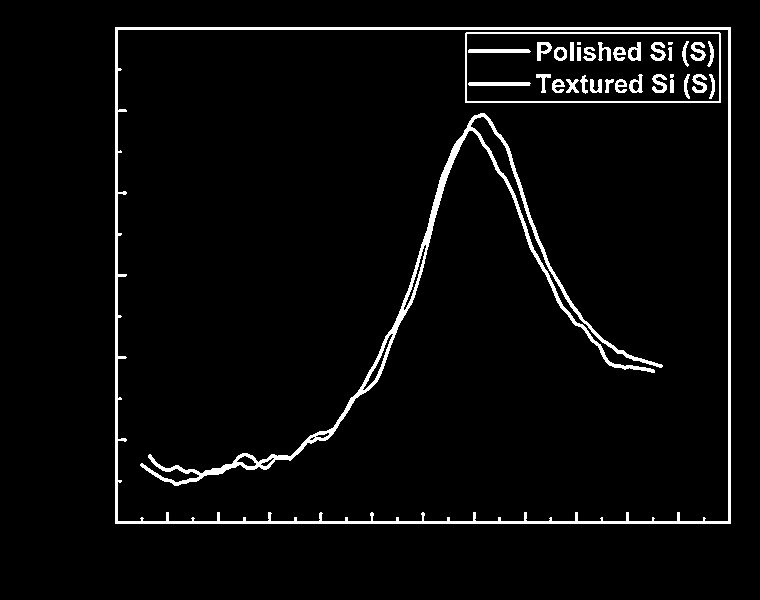

In [ ]:
contours = cv2.findContours(image_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
print(f"Found {len(contours)} contours.")
area_contours = [cv2.contourArea(cnt) for cnt in contours]

print(f"From these contours the largest has and area of {max(area_contours)}. Choosing it as the borders "
              f"of the graph.")

graph_borders = contours[np.argmax(area_contours):np.argmax(area_contours)+1]
# print(np.argmax(area_contours), np.argmax(area_contours)+1)
# graph_borders = contours[20:21]
border_frame = np.zeros(image_binary.shape)
_ = cv2.drawContours(border_frame, graph_borders, -1, 255, 5)
border_frame_filled = np.zeros(image_binary.shape)
_ = cv2.drawContours(border_frame_filled, graph_borders, -1, 255, -1)
data_region = np.zeros(image_binary.shape)
cv2.drawContours(data_region, graph_borders, -1, 255, -1)
data_region = cv2.bitwise_and(data_region.astype(np.uint8), image_binary.astype(np.uint8))
cv2_imshow(data_region)

In [ ]:
# for idy in range(data_region.shape[0]):
#   for idx in range(data_region.shape[1]):
#     if data_region[idy, idx] > 0:
#       left_corner_px = idx
#       exit = True
#       break
#   if exit:
#     exit = False
#     break


def analyze_axis(ref_corner, data_region, axis):
  '''Returns positions of ticks with their corresponding lengths.
  Output list also contains the line of the axis.
  Another output list contains the lenghts of ticks.'''
  # 0: for y - axis
  # 1: for x - axis
  out_axis = []
  axis_tick_lengths = []
  pointers = [0, 0]

  for runner in range(data_region.shape[axis]):
    
    pointers[axis] = runner
    pointers[1-axis] = ref_corner
    
    if data_region[pointers[0], pointers[1]] > 0:
      pos_idx = ref_corner
      neg_idx = ref_corner
      # for determining the length of the ticks
      prev_pix = data_region[pointers[0], pointers[1]]

      if axis == 0:
        while prev_pix == data_region[pointers[0], pos_idx]:
          pos_idx += 1
        while prev_pix == data_region[pointers[0], neg_idx]:
          neg_idx -= 1
      else:
        while prev_pix == data_region[pos_idx, pointers[1]]:
          pos_idx += 1
        while prev_pix == data_region[neg_idx, pointers[1]]:
          neg_idx -= 1
        
    #   # only_data[idy, neg_idx:pos_idx] = 0 # removes the ticks from the image
      tick_length = pos_idx - neg_idx - 1 # calculates the length of ticks
      axis_tick_lengths.append(tick_length)
      out_axis.append([pointers[axis], tick_length])

  return out_axis, axis_tick_lengths

def identify_ticks(axis_with_lenghts, tick_lenghts_in):
  '''Returns the positions of the ticks based on the input tick lenghts and
   their positions on the axis'''
  tmp = np.array(tick_lenghts_in)
  tick_lengths = np.unique(tmp)
  prev = []
  same_length = []
  ticks = []
  line_width = min(tick_lengths) + 1
  
  for id in range(len(axis_with_lenghts)):
    if not axis_with_lenghts[id][1] <= line_width:
      same_length.append(axis_with_lenghts[id][0])
      len_to_app = axis_with_lenghts[id][1]
    else:
      if same_length:
        position = int(np.ceil(np.mean(same_length)))
        ticks.append([position, len_to_app])
        same_length = []
  if len(same_length) > 0:
    position = int(np.ceil(np.mean(same_length)))
    ticks.append([position, len_to_app])
  return ticks

def fetch_ticks_on_axes(data_region):
  '''Returns the positions of all x_ticks and y_ticks. Note that they need to 
  be analyzed as bottom left corner may or may not be a useful tick. "Useful" here
  means that it corresponds to a specific value'''
  # data_region.nonzero()[1][0] represents the first non-zero value, i.e. top left corner
  # this is of course assuming that the image has been cleaned
  y_axis, y_axis_tick_lengths = analyze_axis(data_region.nonzero()[1][0], data_region, 0)
  bottom_left = y_axis[-1][0]
  x_axis, x_axis_tick_lenghts = analyze_axis(bottom_left, data_region, 1)

  y_ticks = identify_ticks(y_axis, y_axis_tick_lengths)
  x_ticks = identify_ticks(x_axis, x_axis_tick_lenghts)
  
  return x_ticks, y_ticks

x_ticks, y_ticks = fetch_ticks_on_axes(data_region)
print(f'Found {len(x_ticks)} x-ticks and {len(y_ticks)} y-ticks')


Found 25 x-ticks and 13 y-ticks


In [ ]:
def analyze_ticks(ticks_in):
  '''Returns the pixel locations of min and max values of an axis.
  These are used later to transform the values from the figure'''
  # Calculate the distance between each tick. In a linear plot, these differences should be more or less same
  # However, 'ticks' contains corner positions. If the distance between the corner and first tick is not the same as
  # average of the distances then it cannot be used as a first tick. (Means that there is no corresponding value on the corner)
  ticks = [ticks_in[i] for i in range(len(ticks_in)) if abs(ticks_in[i][1] - min(ticks_in[:][1])) > 2]
  # calculate differences
  print(ticks)
  ticks_diff = [ticks[id+1][0] - ticks[id][0] for id in range(len(ticks)-1)]
  print(ticks_diff)
  # see if any non-uniform distances are present
  outliers = [id for id in range(len(ticks_diff)) if abs(ticks_diff[id] - float(np.mean(ticks_diff[1:-2]))) > 2]
  
  # check the outliers, if empty then the corner can be considered as the ticks
  # check the left corner and tick next to it
  if abs(ticks_diff[0] - float(np.mean(ticks_diff[1:-2])) ) >= 2:
    px_min = ticks[1][0]
  else:
    px_min = ticks[0][0]

  # check the right corner and tick next to it
  if abs(ticks_diff[-1] - float(np.mean(ticks_diff[1:-2])) ) >= 2:
    px_max = ticks[-2][0]
  else:
    px_max = ticks[-1][0]
  # if not outliers:
  #   px_min = ticks[0][0]
  #   px_max = ticks[-1][0]
  #   print(f"The corner can be considered as the tick.")
  # else:
  #   print('The corner can not be the tick, therefore assigning next in line')
  #   px_min = ticks[1][0]
  #   px_max = ticks[-2][0]
  return px_min, px_max


x_px_min, x_px_max = analyze_ticks(x_ticks)
y_px_min, y_px_max = analyze_ticks(y_ticks)
print(f"The x extreme ticks are {x_px_min} and {x_px_max}")
print(f"The y extreme ticks are {y_px_min} and {y_px_max}")

[[116, 497], [167, 12], [218, 12], [270, 12], [321, 12], [372, 12], [423, 12], [474, 12], [525, 12], [576, 12], [627, 12], [678, 12], [729, 497]]
[51, 51, 52, 51, 51, 51, 51, 51, 51, 51, 51, 51]
[[28, 616], [111, 12], [193, 12], [275, 11], [357, 11], [440, 12], [522, 616]]
[83, 82, 82, 82, 83, 82]
The x extreme ticks are 116 and 729
The y extreme ticks are 28 and 522


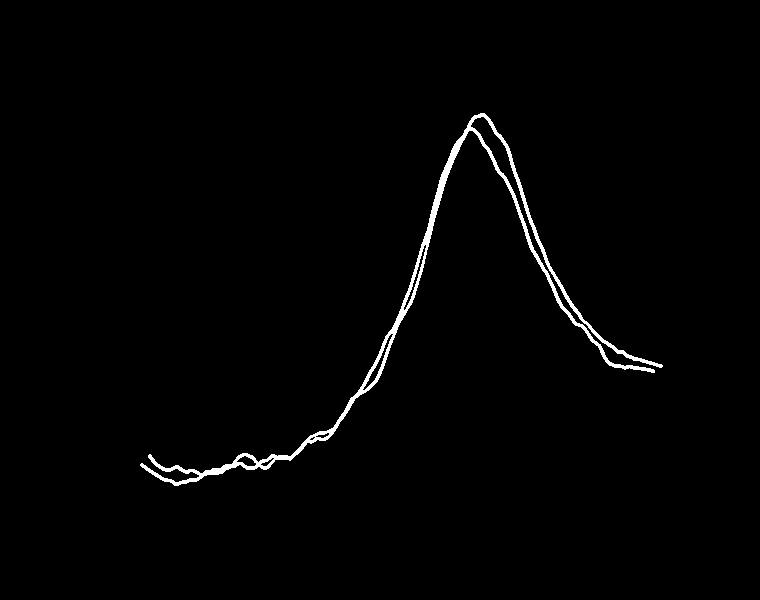

In [ ]:
# # take only the data portion of the graph
data_only = cv2.bitwise_and(data_region, image_binary) - border_frame
data_only[data_only < 0] = 0
#### Not necessary for now
# ### this code cleans um any stray pixels
# kernel1 = np.array([[0, 0, 0],
#                     [0, 1, 0],
#                     [0, 0, 0]], np.uint8)
# kernel2 = np.array([[1, 1, 1],
#                     [1, 0, 1],
#                     [1, 1, 1]], np.uint8)

# data_only_comp = cv2.bitwise_not(data_only)
# hitormiss1 = cv2.morphologyEx(data_only, cv2.MORPH_ERODE, kernel1)
# hitormiss2 = cv2.morphologyEx(data_only_comp, cv2.MORPH_ERODE, kernel2)
# hitormiss = cv2.bitwise_and(hitormiss1, hitormiss2).astype(np.uint8)
# hitormiss_comp = cv2.bitwise_not(hitormiss)  # could just use 255-img

# data_with_legend = cv2.bitwise_and(data_only, data_only, mask=hitormiss_comp)
####



## more cleaning
## find contours, calculate their length (without the borders, the largest should be attributed to lines)
contours = cv2.findContours(data_only.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
# print(f"Found {len(contours)} contours.")
length_contours = [cv2.arcLength(cnt, closed=True) for cnt in contours]
legend_frame = np.zeros(image_binary.shape)

## sort according to arclengths
sorted_args = np.argsort(length_contours)
contours_sorted = []
for i in range(len(contours)):
  contours_sorted.append(contours[sorted_args[i]])

## choose the largest ones to represent the curves
legend_borders = contours_sorted[-1:]
_ = cv2.drawContours(legend_frame, legend_borders, -1, 255, -1)

## choose only data portion
data = cv2.bitwise_and(data_only, legend_frame)
data[data < 255] = 0
cv2_imshow(data)


In [ ]:
#### Color segmentation. To separate the curves in the figure
### Requires knowing how many colors are there
# Initiate necessary variables and reshape them for K-means algorithm
temp = np.zeros(image_in.shape)
img_v2 = image_in.copy()
img_v2[img_v2==[0,0,0]] = img_v2[img_v2==[0,0,0]] + 10

for layer in range(image_in.shape[2]):
  temp[:,:,layer] = cv2.bitwise_and(data.astype(np.uint8), img_v2[:,:,layer].astype(np.uint8))

temp[temp<0] = 0
temp[temp>0] = 255

img = cv2.bitwise_and(img_v2, temp.astype(np.uint8))
Z = np.float32(img.reshape((-1,3)))

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# Input how many colors there are in the image. Includes background color
K = NUM_COLORS + 1
_,labels,centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
labels = labels.reshape((img.shape[:-1]))
result = []

for i, c in enumerate(centers):
    mask = cv2.inRange(labels, i, i)
    result.append(mask)
    


white_px_percent = []
# Calculate the fraction of the white pixels in the image.
# Assume also that white pixels are background so will not treat them as data
for img in result:
  img[img>0] = 255
  white_px_percent.append((len(img[img > 0])/(img.shape[0]*img.shape[1])))

  # The largest segmented color is white. So treating it as a background and
  # save other results as data lines
  data_sep = []
  for perc in white_px_percent:
    if perc != max(white_px_percent):
      data_sep.append(result[white_px_percent.index(perc)])


Separated 2 colored curves.


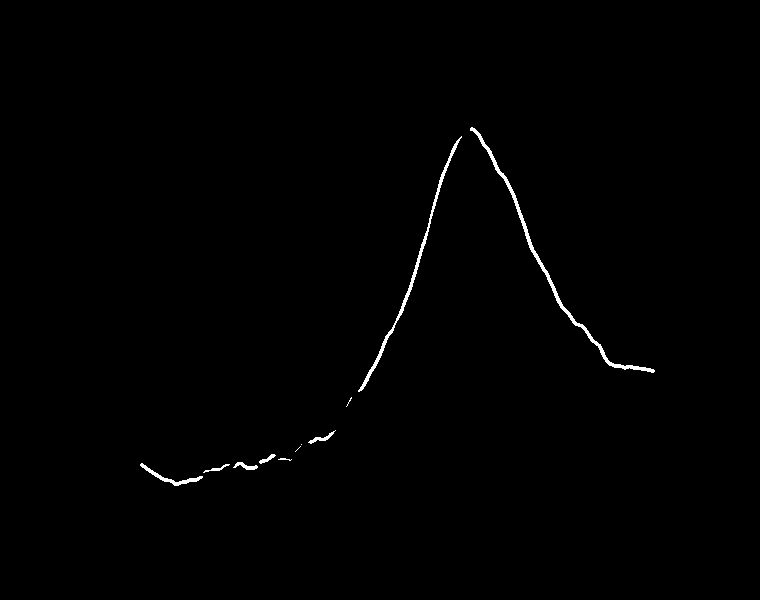

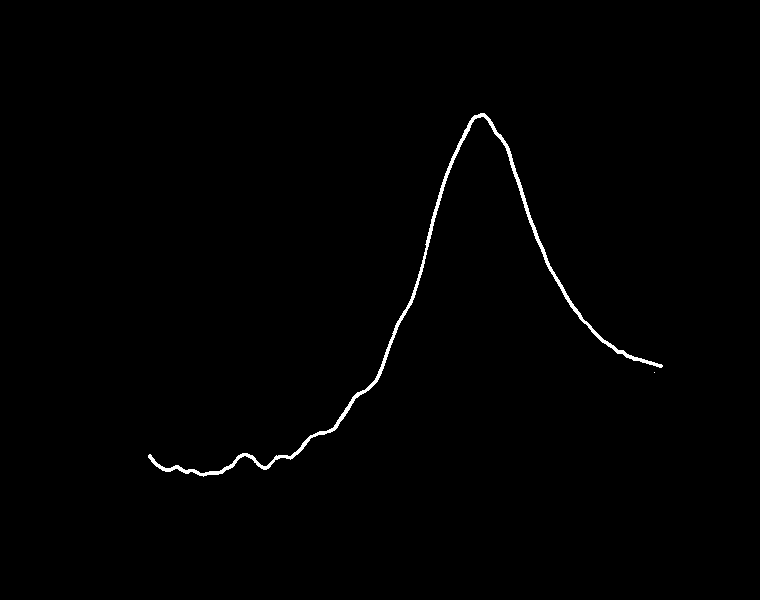

In [ ]:
print(f'Separated {len(data_sep)} colored curves.')
cv2_imshow(data_sep[0])
cv2_imshow(data_sep[1])

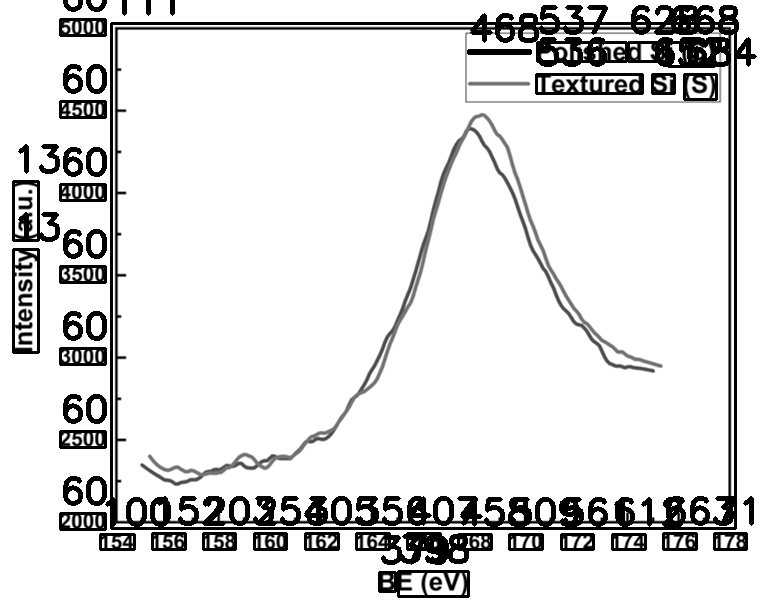

x min: 154.0, x max: 178.0, y min: 2000.0, y max: 5000.0


In [ ]:
results  = pytesseract.image_to_data(image_in, output_type=Output.DICT)
# loop over each of the individual text localizations
for i in range(0, len(results["text"])):
# extract the bounding box coordinates of the text region from
# the current result
  # extract the OCR text itself along with the confidence of the
  # text localization
  text = results["text"][i]
  conf = int(results["conf"][i])

  if conf > 0:
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]

    text = str(x)

    cv2.rectangle(image_grey, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image_grey, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
      1.2, (0, 0, 255), 3)
cv2_imshow(image_grey)

text_df = pd.DataFrame(results)
text_df.drop(['page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'level',
              'width', 'height'], inplace=True, axis=1)
text_df['conf'] = text_df['conf'].astype(int)
text_df = text_df.loc[text_df.conf > 0]
text_df['text'] = pd.to_numeric(text_df['text'], errors='coerce')
text_df.dropna(inplace=True)

y_labels = text_df[abs(text_df.left.iat[0] - text_df.left) < 10]
x_labels =  text_df[(abs(text_df.left.iat[0] - text_df.left) >= 10)]

x_min = x_labels.text.iat[0]
x_max = x_labels.text.iat[-1]
y_min = y_labels.text.iat[-1]
y_max = y_labels.text.iat[0]
print(f"x min: {x_min}, x max: {x_max}, y min: {y_min}, y max: {y_max}")

In [ ]:
all_curves = []

for data_curve in data_sep:
  curve = []
  locations = []
  for idx in range(data_curve.shape[1]):
    locations = np.nonzero(data_curve[:,idx])[0]
    if locations.any():
      curve.append([idx, int(np.ceil(locations.mean()))])
  all_curves.append(curve)
print(f"Recorded the pixel locations along the y-axis of the curves")

Recorded the pixel locations along the y-axis of the curves


In [ ]:
def linear_axis_transform(xmax, xmin, ymax, ymin, px):
    slope = (ymax-ymin)/(xmax-xmin)
    intercept = ymax - slope*xmax
    return intercept + slope*px
x_all = []
y_all = []

# x_min = -0.2
# x_max = 1
# y_min = 0
# y_max = 35
for curve in all_curves:
  xdata = []
  ydata = []
  for coord in curve:
    xdata.append(linear_axis_transform(xmax=x_px_max, xmin=x_px_min, ymax=x_max, ymin=x_min, px=coord[0]) )
    ydata.append(linear_axis_transform(xmax=y_px_min, xmin=y_px_max, ymax=y_max, ymin=y_min, px=coord[1]) )
  x_all.append(xdata)
  y_all.append(ydata)
  # reproduced_data = pd.DataFrame({"X": xdata,
                                  # "Y": ydata})


(154.0, 178.0)

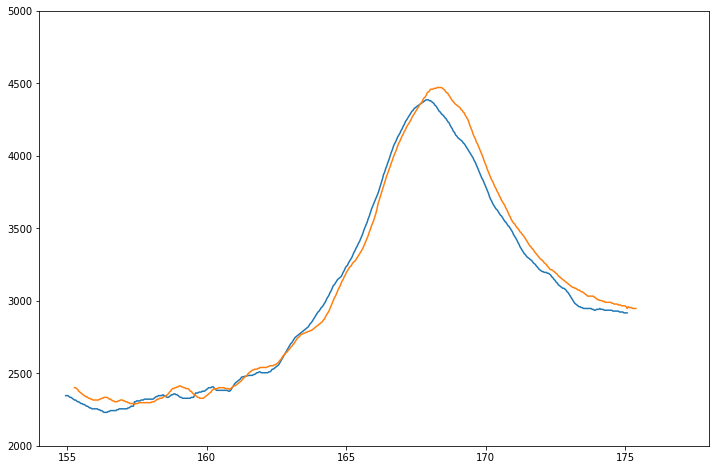

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(len(x_all)):
  ax.plot(x_all[i], y_all[i])
ax.set_ylim([y_min, y_max])
ax.set_xlim([x_min, x_max])

In [ ]:
to_df = {'X data': xdata, 'Y data': ydata}
df = pd.DataFrame(to_df)

In [ ]:
df

,X data,Y data
0,155.252855,2400.809717
1,155.292007,2400.809717
2,155.331158,2394.736842
3,155.370310,2388.663968
4,155.409462,2376.518219
...,...,...
510,175.220228,2953.441296
511,175.259380,2947.368421
512,175.298532,2947.368421
513,175.337684,2947.368421
